This notebook: take what was developed in `N400.ipynb` and sanity-check on the actual Broderick et al 2018 N400 dataset.

In [1]:
import itertools
from pathlib import Path

import mne
import nltk
import numpy as np
import pandas as pd
import re
import scipy.io
from tqdm.notebook import tqdm

# Transformers prep
import os
os.environ["TRANSFORMERS_CACHE"] = str((Path(".") / "transformers_cache").resolve())
import transformers
import torch
RECOMPUTE_SURPRISALS = False

DATA_DIR = Path("/om/data/public/broderick2018/N400")
EEG_DIR = DATA_DIR / "EEG"
STIM_FILE = DATA_DIR / "Stimuli" / "Sentences.txt"

In [2]:
# Metadata for Broderick et al 2018
NUM_DATA_CHANNELS = 128
# 2 mastoid channels
NUM_REFERENCE_CHANNELS = 2
NUM_CHANNELS = NUM_DATA_CHANNELS + NUM_REFERENCE_CHANNELS
SAMPLE_RATE = 128

data_channels = [f"V{i + 1}" for i in range(NUM_DATA_CHANNELS)]
reference_channels = [f"M{i + 1}" for i in range(NUM_REFERENCE_CHANNELS)]
channel_names = data_channels + reference_channels

# EEG Processing parameters
EPOCH_WINDOW = (-0.2, 0.7)
TEST_WINDOW = (0.4, 0.45)

# EEG band-pass filter parameters
FILTER_LOW = 1.
FILTER_HIGH = 8.

In [3]:
%load_ext autoreload
%autoreload 2
import utils

In [38]:
BRODERICK_EPOCH_TMIN = -0.1
BRODERICK_EPOCH_TMAX = 0.7

In [119]:
EEG_DIR = Path("broderick2018/N400/EEG")

for idx in range(1, 10):
    data = scipy.io.loadmat(EEG_DIR / f"Subject{idx}.mat")
    
    try:
        np.testing.assert_equal(data["eegData_hiCloze"], data["eegData_loCloze"])
    except:
        print(f"Subject {idx} has differing high- and low-cloze data.")
    else:
        print(f"Subject {idx} has the SAME high- and low-cloze data.")

Subject 1 has the SAME high- and low-cloze data.
Subject 2 has the SAME high- and low-cloze data.
Subject 3 has the SAME high- and low-cloze data.
Subject 4 has the SAME high- and low-cloze data.
Subject 5 has the SAME high- and low-cloze data.
Subject 6 has the SAME high- and low-cloze data.
Subject 7 has the SAME high- and low-cloze data.
Subject 8 has the SAME high- and low-cloze data.
Subject 9 has the SAME high- and low-cloze data.


In [120]:
data["mastoids_loCloze"][0]

array([[-11467.071 , -11472.873 , -11471.39  , ...,  -7803.503 ,
         -7849.871 ,  -7815.7764],
       [-11467.326 , -11470.376 , -11467.142 , ...,  -7778.0054,
         -7844.358 ,  -7804.766 ],
       [-11466.014 , -11471.668 , -11473.688 , ...,  -7764.9365,
         -7837.6587,  -7810.699 ],
       ...,
       [-11473.331 , -11469.67  , -11495.502 , ...,  -7784.001 ,
         -7816.2393,  -7795.961 ],
       [-11476.721 , -11478.991 , -11489.718 , ...,  -7787.0186,
         -7829.3467,  -7791.2476],
       [-11469.306 , -11494.422 , -11481.857 , ...,  -7784.8594,
         -7833.6416,  -7799.294 ]], dtype=float32)

In [121]:
data["mastoids_hiCloze"][0]

array([[-11462.849 , -11461.286 , -11403.646 , ...,  -7816.7915,
         -7722.663 ,  -7707.605 ],
       [-11459.308 , -11458.841 , -11400.221 , ...,  -7816.5376,
         -7720.1357,  -7709.8813],
       [-11456.54  , -11460.083 , -11398.433 , ...,  -7817.317 ,
         -7727.7964,  -7717.5654],
       ...,
       [-11425.988 , -11424.4375, -11407.307 , ...,  -7808.671 ,
         -7732.048 ,  -7737.2593],
       [-11432.259 , -11435.507 , -11410.458 , ...,  -7806.7773,
         -7734.8833,  -7736.436 ],
       [-11435.922 , -11431.974 , -11413.168 , ...,  -7800.156 ,
         -7730.139 ,  -7735.0186]], dtype=float32)

In [ ]:
test = scipy.io.loadmat(EEG_DIR / "Subject1.mat")

In [126]:
def load_epochs(times, data, mastoid_data, event_name, event_id):
    """
    Process data from Broderick et al N400 experiment.
    
    Below, n_samples = num samples per epoch.
    
    Args:
        times: ndarray 1 * n_samples
        data: ndarray n_channels * n_samples * n_epochs
        mastoid_data: ndarray n_mastoid_channels * n_samples * n_epochs
        event_id: desired event ID describing epoch event
    """
    # NB does not check that `channel_names` etc. is consistent with channel count in data
    
    n_samples = times.shape[1]
    mne_info = mne.create_info(ch_names=channel_names, ch_types=["eeg"] * len(channel_names),
                               sfreq=SAMPLE_RATE)
    
    # Simulate events representation -- add an event at t=0 for each epoch.
    # Find the sample closest to t=0 in each epoch.
    onset_idx = np.abs(times - 0).flatten().argmin()
    event_sample_idxs = np.arange(data.shape[2]) * n_samples + onset_idx
    event_arr = np.column_stack([
        event_sample_idxs,
        np.zeros_like(event_sample_idxs),
        event_id * np.ones_like(event_sample_idxs)
    ])
    
    # Concatenate + reshape data; create MNE epochs representation.
    epoch_data_raw = np.transpose(np.concatenate([data, mastoid_data], axis=0), (2, 0, 1)) / 1e6
    epoch_data = mne.EpochsArray(epoch_data_raw, mne_info, tmin=BRODERICK_EPOCH_TMIN,
                                 events=event_arr, event_id={event_name: event_id}) \
        .set_eeg_reference(reference_channels) \
        .apply_baseline()
    
    epoch_data.average().plot()
    
    return epoch_data

In [169]:
def prepare_subject_df(raw_mat, test_window):
    """
    Args:
        raw_mat: Raw .mat data from Broderick dataset
        test_window: (start, end) in seconds relative to epoch t=0
    """
    event_ids = {"loCloze": 1, "hiCloze": 2}

    epochs = mne.concatenate_epochs([
        load_epochs(raw_mat["TimeAxis"], raw_mat["eegData_loCloze"], raw_mat["mastoids_loCloze"], event_name="loCloze", event_id=1),
        load_epochs(raw_mat["TimeAxis"], raw_mat["eegData_hiCloze"], raw_mat["mastoids_hiCloze"], event_name="hiCloze", event_id=2),
    ])
    
    epochs_df = epochs.crop(*test_window).to_data_frame()
    return epochs_df

  0%|          | 0/9 [00:00<?, ?it/s]

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


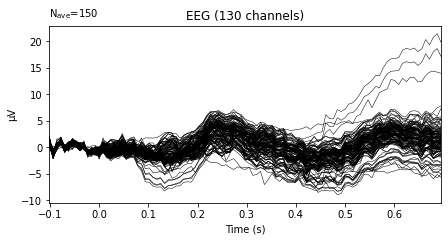

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


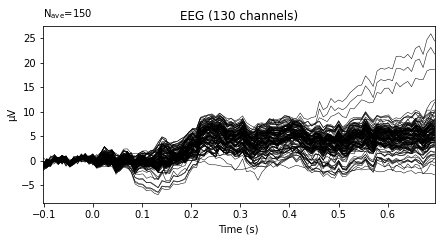

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


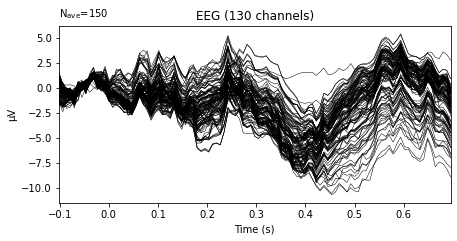

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


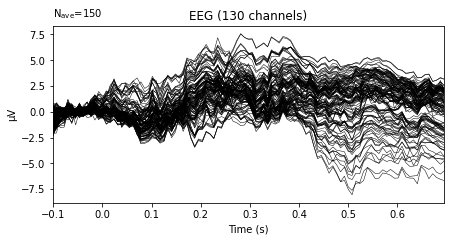

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


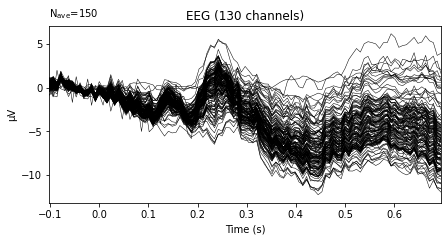

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


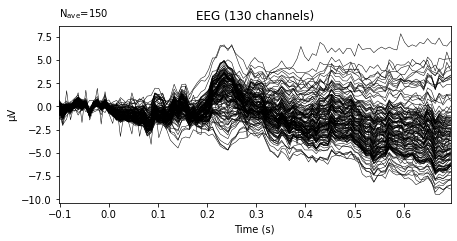

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


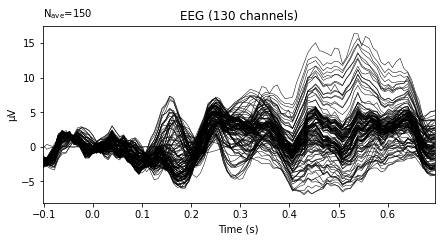

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


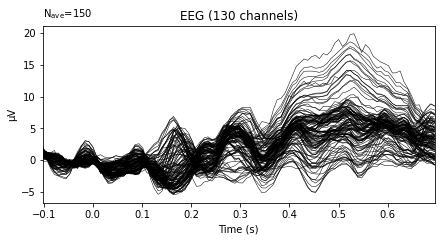

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


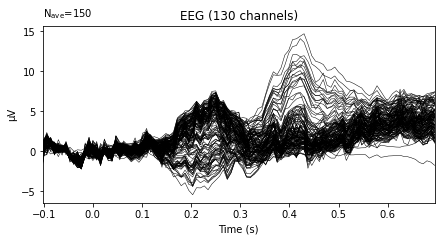

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


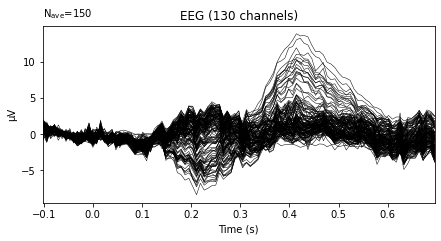

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


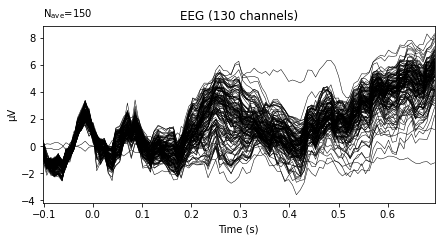

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


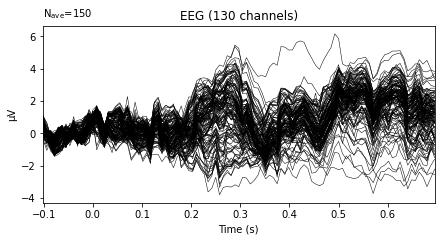

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


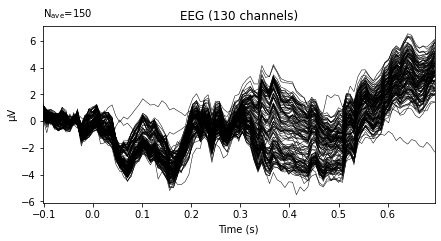

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


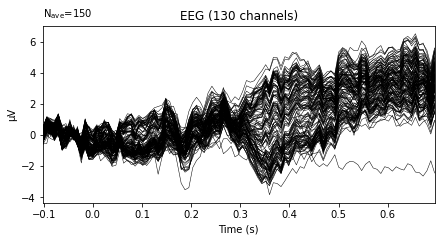

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


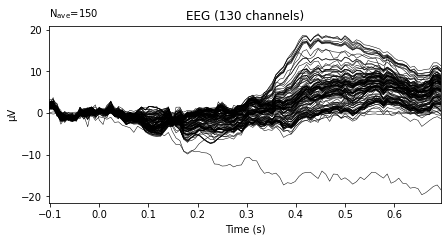

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


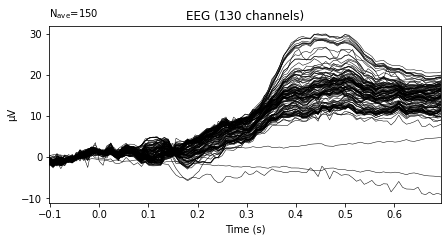

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


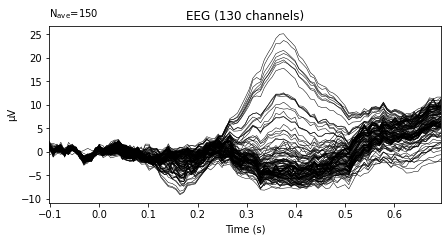

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


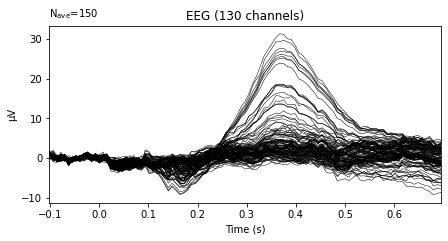

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped


time condition  epoch         V1         V2         V3  \
subject                                                                
1       0      398   loCloze      0   2.582275   1.381417   0.823389   
        1      406   loCloze      0  -0.655002  -1.467498  -1.661380   
        2      414   loCloze      0   3.505448   2.494639   2.844825   
        3      422   loCloze      0   0.096109  -1.497417  -1.439725   
        4      430   loCloze      0  -1.025320  -1.271047  -1.796421   
...            ...       ...    ...        ...        ...        ...   
9       2395   422   hiCloze    299 -28.172175 -12.884316 -17.256609   
        2396   430   hiCloze    299 -25.108357  -7.619782 -11.924554   
        2397   438   hiCloze    299 -15.830289   2.643626  -3.880023   
        2398   445   hiCloze    299 -10.495440   7.395466   0.636193   
        2399   453   hiCloze    299 -15.411659   4.346549  -3.237876   

                     V4         V5         V6         V7  ...       V121  \
subject                                                   ...              
1       0     -4.966477  -9.136108  -8.644802 -10.349389  ...  -3.796603   
        1     -6.006765 -10.295139 -11.584056 -13.968508  ...  -6.689291   
        2     -0.379714  -7.139818  -7.672501 -11.623438  ...  -6.532829   
        3     -5.389298 -12.107493 -12.425972 -17.189022  ... -12.329380   
        4     -3.124321  -9.047167  -8.012434 -11.253703  ...  -3.357950   
...                 ...        ...        ...        ...  ...        ...   
9       2395  -6.156707  -7.460892   4.783422   5.524639  ...  11.878802   
        2396  -0.095893  -1.906717  10.064778  12.491630  ...  17.579631   
        2397   5.979357   0.855819  11.429049  13.620277  ...  16.541498   
        2398  11.611297   4.361550  11.720961  13.636226  ...  20.279536   
        2399   8.881824   4.083317  10.176479  11.674045  ...  16.653737   

                   V122       V123      V124       V125       V126      V127  \
subject                                                                        
1       0     -2.476786  -9.219029 -0.490940   1.694475  -2.613025 -2.914241   
        1     -4.255612 -10.278874 -1.209921  -1.850139  -5.423757 -6.214849   
        2     -4.214634  -9.030902 -0.135175  -0.410314  -7.889899 -8.949212   
        3    -12.495954 -15.963667 -6.727076  -3.492992  -7.327380 -7.485173   
        4     -4.049790  -4.794316 -1.408293   4.383203  -1.865173 -2.388044   
...                 ...        ...       ...        ...        ...       ...   
9       2395   0.160254   9.409368 -1.685108 -15.973396   4.768239 -4.166737   
        2396   8.601063  17.885102  5.314014  -7.135378  14.938048  3.852649   
        2397   5.983465  14.492760  2.577439 -10.134004  14.203933  1.689419   
        2398   6.769850  16.733522  3.846134 -10.050650  16.987889  4.863134   
        2399   3.893111  14.367031  0.676144 -12.541938  14.158298  4.662201   

                   V128         M1         M2  
subject                                        
1       0     -2.608768 -21.113881  21.113881  
        1     -5.218333 -20.996534  20.996534  
        2     -8.129648 -16.894990  16.894990  
        3     -6.974808 -11.087262  11.087262  
        4     -2.373143 -19.078941  19.078941  
...                 ...        ...        ...  
9       2395   6.583636   7.292455  -7.292455  
        2396  13.709650   4.542493  -4.542493  
        2397  13.015815   3.874501  -3.874501  
        2398  20.105741   4.488942  -4.488942  
        2399  19.203289   5.152742  -5.152742  

[21600 rows x 133 columns]

In [171]:
subject_re = re.compile(r"Subject(\d+)\.mat")
all_paths = list(EEG_DIR.glob("*.mat"))
all_data = pd.concat({subject_re.match(path.name).group(1): prepare_subject_df(scipy.io.loadmat(path), TEST_WINDOW)
                      for path in tqdm(all_paths)},
                      names=["subject"])
all_data

## Statistical test

In [191]:
def main_effect_test(electrode_data):
    electrode_data = electrode_data.groupby(["condition", "epoch"]).value.mean()
    return pd.Series(scipy.stats.ttest_ind(electrode_data.loc["hiCloze"], electrode_data.loc["loCloze"]),
                     index=["tval", "pval"])
    
ttest_results = all_data.reset_index("subject").melt(id_vars=["subject", "time", "condition", "epoch"], var_name="electrode") \
    .set_index(["electrode", "condition"]) \
    .groupby("electrode") \
    .apply(main_effect_test)

In [192]:
ttest_results.sort_values("pval")

,tval,pval
electrode,,
V20,4.516375,0.000009
V21,4.484457,0.000010
V18,4.479454,0.000011
V5,4.423410,0.000014
V16,4.407535,0.000015
...,...,...
V95,2.441098,0.015225
V94,2.320665,0.020980
V93,2.195660,0.028887


### Permutation test sanity check

In [193]:
# Permutation test.
sanity_check = all_data.copy()
sanity_check["condition"] = np.random.randint(2, size=len(sanity_check))

In [194]:
def sanity_main_effect_test(electrode_data):
    electrode_data = electrode_data.groupby(["condition", "epoch"]).value.mean()
    return pd.Series(scipy.stats.ttest_ind(electrode_data.loc[0], electrode_data.loc[1]),
                     index=["tval", "pval"])
    
ttest_sanity_results = sanity_check.reset_index("subject").melt(id_vars=["subject", "time", "condition", "epoch"], var_name="electrode") \
    .set_index(["electrode", "condition"]) \
    .groupby("electrode") \
    .apply(sanity_main_effect_test)

In [195]:
ttest_sanity_results.sort_values("pval")

,tval,pval
electrode,,
V101,1.296034,0.195464
V96,1.174864,0.240517
V102,1.096391,0.273349
V90,1.093519,0.274606
V91,1.084752,0.278469
...,...,...
V25,0.307689,0.758426
M2,0.298703,0.765271
M1,-0.298703,0.765271
